# E08 Spiking neural networks (*Solution*)

In this week's homework, we are going to use the code from the tutorial and look at the effect of changes in its parameters in a more systematic way.

In [1]:
# Import Brian and switch off its "code generation" facility
from brian2 import *
prefs.codegen.target = 'numpy'
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This code is slightly adapted from the tutorial (slightly different names for parameters, and returns spike count)
# See the comments in the tutorial code for more details
def run_sim(input_rate, g, N_E=2000):
    start_scope()
    # network parameters
    gamma = 0.25
    N_I = int(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = C_ext = int(epsilon * N_E)
    C_I = int(epsilon * N_I)

    # neuron parameters
    tau = 20 * ms; theta = 20 * mV; V_r = 10 * mV; tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV; D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    neurons = NeuronGroup(N,"dv/dt = -v/tau : volt (unless refractory)",
                          threshold="v > theta", reset="v = V_r",
                          refractory=tau_rp, method="exact")

    exc_neurons = neurons[:N_E]
    inh_neurons = neurons[N_E:]
    exc_synapses = Synapses(exc_neurons, neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(i='k for k in sample(N_E, size=C_E)')
    inhib_synapses = Synapses(inh_neurons, neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(i='k for k in sample(N_I, size=C_I)')

    nu_ext = input_rate * nu_thr
    external_poisson_input = PoissonInput(target=neurons, target_var="v",
                                          N=C_ext, rate=nu_ext, weight=J)

    rate_monitor = PopulationRateMonitor(neurons)
    exc_monitor = SpikeMonitor(exc_neurons)  # record excitatory neurons
    state_monitor = StateMonitor(exc_neurons, 'v', record=0)  # record membrane potential of one neuron
    run(0.5*second)
    
    return {'exc_spikes_t': exc_monitor.t, 'exc_spikes_i': exc_monitor.i, 'exc_spikes_count': exc_monitor.count}

In our model, each of the neurons in the network receives input via a `PoissonInput`. This models the summed effect of many neurons providing excitatory input to the cell, each spiking randomly according to a Poisson process. This is more efficient than actually simulating each of the external input cells and their synapses individually. 
The `input_rate` parameter that we provide to the `run_sim` function determines the *firing rate* of these external input neurons (as a value relative to the rate that is necessary to have an average input current that drives the neuron to its threshold), i.e. higher values means that each neuron in the network gets stronger external input.

## Question: how does the network activity depend on the input rate and the strength of the inhibition?

To answer this question, we will first simulate the network several times, with different values for the external input rate `input_rate` and for the strength of the inhibitory synapses `g`. For each parameter combination below, store the *mean firing* rate of the excitatory neurons in the `firing_rate` matrix, and the *standard deviation of the firing rates* across excitatory neurons in the `firing_rate_stddev` matrix.

**Hints**:
  * The `results` dictionary returned by `run_sim`, contains an entry `exc_spikes_count` with an array containing the total number of spikes for each neuron.
  * Each simulation runs for 0.5s

In [9]:
# Parameters that we are varying
g_values = [0, 2, 4, 6, 8]
input_rate_values = [1, 2, 3]

# Empty matrices of the appropriate size
firing_rate = np.empty((len(input_rate_values), len(g_values)))
firing_rate_stddev = np.empty((len(input_rate_values), len(g_values)))

print('Running')
for input_rate_index, input_rate_value in enumerate(input_rate_values):
    for g_index, g_value in enumerate(g_values):
        results = run_sim(input_rate_value, g_value)
        # Calculate firing rates
        # -- SOLUTION
        firing_rates = results['exc_spikes_count'] / (0.5*second)  # divide by duration to get rate
        # --
        # Store mean firing rate in `firing_rate`
        firing_rate[input_rate_index, g_index] = np.mean(firing_rates)  # SOLUTION
        
        # Store standard deviation of firing rates
        firing_rate_stddev[input_rate_index, g_index] = np.std(firing_rates)  # SOLUTION
        print('.', end='')  # Print a dot to show progress
print('\nFinished')

Running
...............
Finished


We will now plot the mean firing rate and its standard deviation over neurons as a function of the external input rate, separately for the different strengths of inhibition.

**Hints**:
  * Use `plt.errorbar` to plot lines (for the mean firing rate) with error bars (for the standard deviation). The syntax is `plt.errorbar(x_values, y_values, error_values)`
  * If you add `label=f'g = {g_value}'` to the `plt.errorbar` call, the legend shows the strength of the inhibition in the label
  * Note that the error bars will most likely be very small and therefore almost invisible.

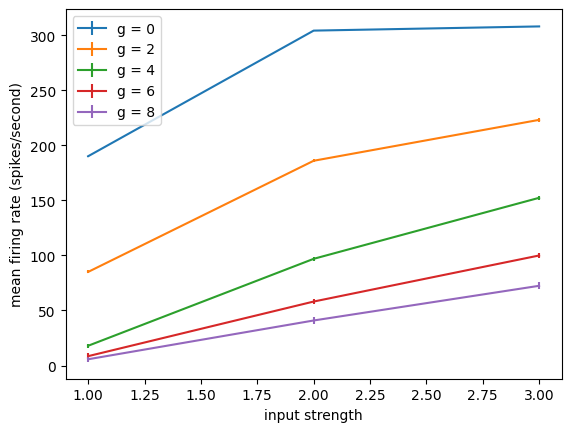

In [10]:
for g_index, g_value in enumerate(g_values):
    plt.errorbar(input_rate_values, firing_rate[:, g_index], firing_rate_stddev[:, g_index],
                 label=f'g = {g_value}')
    plt.legend()
    plt.ylabel('mean firing rate (spikes/second)')
    plt.xlabel('input strength');

We will now analyze the firing of individual cells, to see whether they are firing regularly or irregularly.

To do this, we will first calculate the **ISI** (interspike intervals = time between spikes) for each recorded neuron, calculate their **CV** (coefficient of variation = standard deviation divided by mean), and finally calculate the **average CV** across the population

*Hint:*
* Use numpy's `diff` function

In [11]:
# We are doing the simulations again for simplicity

# Parameters that we are varying
g_values = [0, 2, 4, 6, 8]
input_rate_values = [1, 2, 3]

# Empty matrices of the appropriate size
average_CV = np.empty((len(input_rate_values), len(g_values)))

print('Running')
for input_rate_index, input_rate_value in enumerate(input_rate_values):
    for g_index, g_value in enumerate(g_values):
        results = run_sim(input_rate_value, g_value)
        CVs = []
        # get spikes for each neuron
        for idx in range(1000):
            spike_times = results['exc_spikes_t'][results['exc_spikes_i'] == idx]  # get spikes for this neuron only
            if len(spike_times) > 1:  # skip neurons that did not spike or only spiked once
                # Calculate ISIs
                # -- SOLUTION
                ISIs = np.diff(spike_times)
                # --
                CV = np.std(ISIs) / np.mean(ISIs)  # SOLUTION
                CVs.append(CV)
        # Store average CV
        if len(CVs):
            average_CV[input_rate_index, g_index] = np.mean(CVs)
        else:  # no neuron spiked, we cannot calculate anything
            average_CV[input_rate_index, g_index] = np.nan  # NaN = "Not a Number"
        print('.', end='')  # Print a dot to show progress
print('\nFinished')

Running
...............
Finished


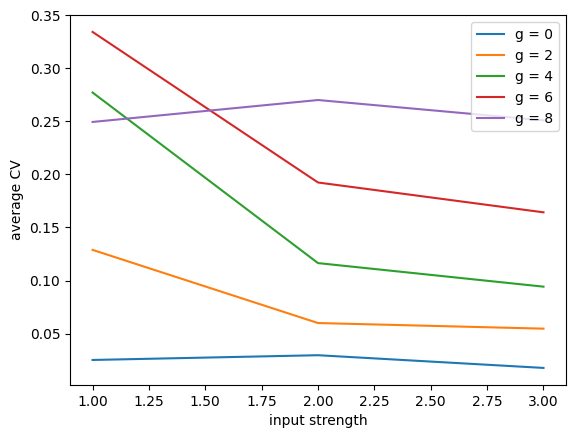

In [12]:
for g_index, g_value in enumerate(g_values):
    plt.plot(input_rate_values, average_CV[:, g_index], label=f'g = {g_value}')
    plt.legend()
    plt.ylabel('average CV')
    plt.xlabel('input strength');